In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
os.environ["OPENBLAS_NUM_THREADS"] = "20"
os.environ["NUMEXPR_NUM_THREADS"] = "20"

import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib
import classD_1dMFGTN
importlib.reload(classD_1dMFGTN)
from classD_1dMFGTN import classD_1d_MFGTN

# Global parameters (adjust as needed)
N = 32
nshell = 1
samples = 1


In [6]:
def run_entanglement_contour(top_parameters = (3, 0, 1, 1), nshell = 1, cycles=20, samples=100, progress=True, sites_A = None, init = "random_pure"):
    """
    Initialize maximally mixed top layer, run many samples in parallel,
    and return sample-averaged entanglement contour over time.

    top_parameters: 4-tuple
    """
    
    mu_1, mu_2, t_1, t_2 = top_parameters
    model = classD_1d_MFGTN(N=N, DW=True, nshell=nshell, mu_1=mu_1, mu_2=mu_2, t_1=t_1, t_2=t_2)
    x0_DW = model.DW_loc[0]
    x1_DW = model.DW_loc[1]
    result = model.run_adaptive_circuit(
        cycles=cycles,
        G_history=True,
        progress=progress,
        postselect=False,
        samples=samples,
        parallelize_samples=True,
        n_jobs=50,
        store="top",
        init_mode=init,
        save=False,
    )

    G_hist = result["G_hist"]  # (S, T, 2N, 2N)
    S, T = G_hist.shape[:2]
    if sites_A is None:
        sites_A = np.arange(N//2)  # Left half by default
    contour_samples = []
    desc = "Computing entanglement contour (samples x time)"
    for s in tqdm(range(S), desc=desc):
        contours_t = []
        for t in range(T):
            contours_t.append(model.compute_entanglement_contour(G_hist[s, t], sites_A))
        contour_samples.append(np.stack(contours_t, axis=0))

    contour_samples = np.stack(contour_samples, axis=0)  # (S, T, N)
    contour_mean = np.mean(contour_samples, axis=0)      # (T, N)
    times = np.arange(T)
    dw_loc = getattr(model, "DW_loc", (None, None))
    return contour_mean, times, dw_loc


In [ ]:
def plot_contour_heatmap(contour_mean, samples, times, dw_loc, outdir="results", save_data=False, save_plot=False):
    os.makedirs(outdir, exist_ok=True)

    if save_data:
        data_path = os.path.join(outdir, f"entanglement_contour_maxmix_{samples}_samples.npz")
        np.savez_compressed(
            data_path,
            contour_mean=contour_mean,
            times=times,
            dw_loc=np.array(dw_loc),
        )

    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(
        contour_mean/np.log(2),
        origin="lower",
        aspect="auto",
        cmap="Blues",
        extent=(-0.5, contour_mean.shape[1] - 0.5, -0.5, contour_mean.shape[0] - 0.5),
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r"$\overline{s_i}/\log2$")

    ax.set_xlabel("Local Majorana index")
    ax.set_ylabel("Time step")
    ax.set_title(f"Half-System Entanglement Contour $(\log 2)$ | {samples} samples | sites={N} | nshell={nshell}")

    # Major ticks every cell, labels every 5
    ax.set_xticks(np.arange(contour_mean.shape[1]))  # left edge of each cell
    ax.set_yticks(np.arange(contour_mean.shape[0]))
    ax.set_xticklabels([str(x) if x % 5 == 0 else "" for x in range(contour_mean.shape[1])])
    ax.set_yticklabels([str(y) if y % 5 == 0 else "" for y in range(contour_mean.shape[0])])

    # Minor ticks for gridlines
    ax.set_xticks(np.arange(-0.5, contour_mean.shape[1], 1)[0::2], minor=True)
    ax.set_yticks(np.arange(-0.5, contour_mean.shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", alpha=0.4, linewidth=0.5)
    ax.tick_params(which="minor", length=0)

    # Domain-wall annotation
    if dw_loc is not None and len(dw_loc) == 2:
        dw_text = f"DWs at x = {dw_loc[0]}, {dw_loc[1]}"
        ax.text(
            0.02, 0.98, dw_text,
            transform=ax.transAxes,
            va="top", ha="left",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7),
        )

    fig.tight_layout()
    if save_plot:
        fname = os.path.join(outdir, f"entanglement_contour_maxmix_{samples}_samples.png")
        fig.savefig(fname, dpi=300, bbox_inches="tight")
        print(f"Saved contour data to {data_path}")
        print(f"Saved contour heatmap to {fname}")


------------------------- classD_1d_MFGTN Initialized -------------------------


Adaptive circuit | N=32, cycles=20, nshell=1, DW=1, mu1=1.00, mu2=0.00, sigma=0.00:   0%|          | 0/640 [00…

Total elapsed: 80.73 s


Computing entanglement contour (samples x time): 100%|██████████| 1/1 [00:00<00:00, 73.94it/s]

Total time elapsed: 1.3 min


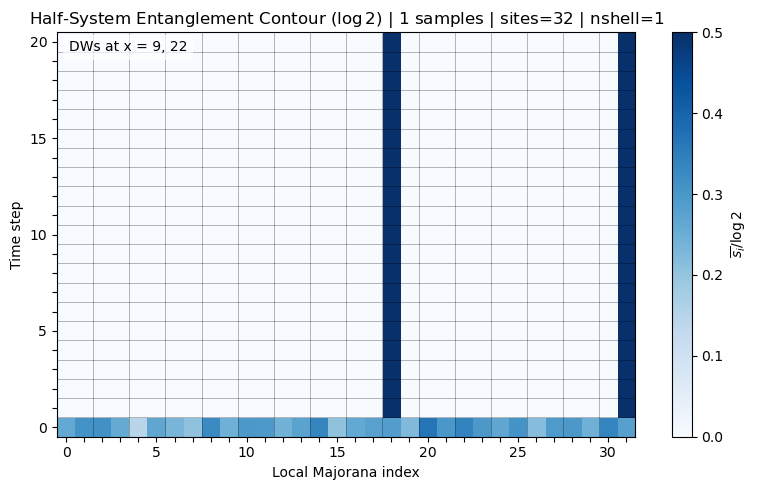

In [9]:
samples = 1
t0 = time.time()
top_params = (1, 0, 0, 1) # mu_1, mu_2, t_1, t_2
contour_mean, times, dw_loc = run_entanglement_contour(top_parameters = top_params, cycles=20, samples=samples, progress=True)
plot_contour_heatmap(contour_mean, samples, times, dw_loc)
elapsed = time.time() - t0
print(f"Total time elapsed: {elapsed/60:.1f} min")


Saved contour curves plot to results/entanglement_contour_curves.png


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Entanglement Contour Slices vs Interleaved Majorana Index'}, xlabel='Interleaved Majorana index $(\\gamma_{1,i}, \\gamma_{2,i})$', ylabel='$s_i / \\log 2$'>)

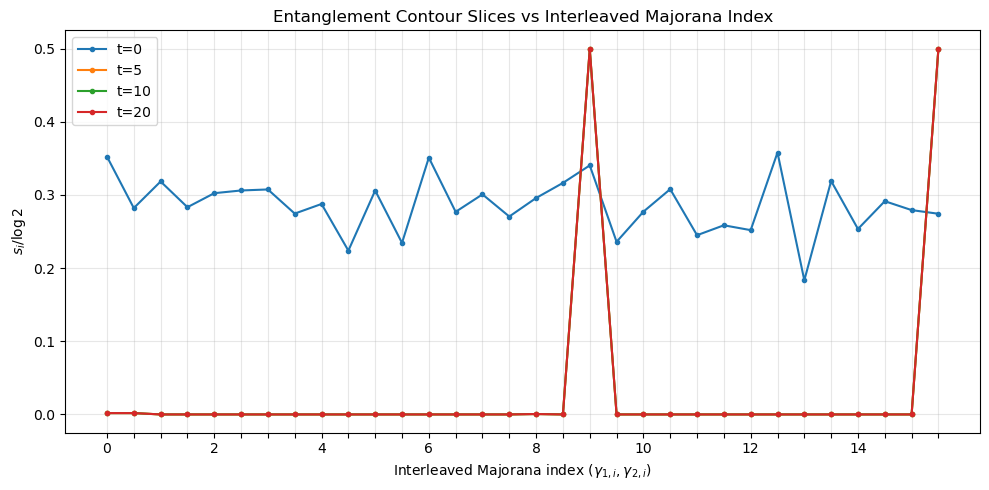

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_contour_curves(contour_mean, time_points=(0, 5, 10, 20), outdir="results", save_plot=False):
    os.makedirs(outdir, exist_ok=True)
    max_t = contour_mean.shape[0] - 1
    sel_times = [t for t in time_points if 0 <= t <= max_t]
    if not sel_times:
        raise ValueError(f"No valid times in {time_points}; available range 0..{max_t}")

    # Interleaved Majorana tick labels: [γ1_0, γ2_0, γ1_1, γ2_1, ...]
    n_sites = contour_mean.shape[1] // 2
    ticks = np.arange(2 * n_sites)
    labels = [str(i // 2) if (i % 2 == 0 and (i // 2) % 2 == 0) else "" for i in ticks]

    fig, ax = plt.subplots(figsize=(10, 5))
    for t in sel_times:
        ax.plot(ticks, contour_mean[t] / np.log(2), "-o", markersize=3, label=f"t={t}")

    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_xlabel(r"Interleaved Majorana index $(\gamma_{1,i}, \gamma_{2,i})$")
    ax.set_ylabel(r"$s_i / \log 2$")
    ax.set_title("Entanglement Contour Slices vs Interleaved Majorana Index")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()

    if save_plot:
        fname = os.path.join(outdir, "entanglement_contour_curves.png")
        fig.savefig(fname, dpi=300, bbox_inches="tight")
        print(f"Saved contour curves plot to {fname}")

    return fig, ax

# Example usage:
plot_contour_curves(contour_mean, time_points=(0, 5, 10, 20), save_plot=True)
